In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import tqdm as tqdm

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (16,8)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('train.csv', encoding = 'cp949')
test = pd.read_csv('test.csv',encoding = 'cp949')
submission = pd.read_csv('sample_submission.csv', encoding = 'cp949')

In [3]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [4]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 결측치 확인하기
print('train 결측치', '\n' ,train.isnull().sum())
print('test 결측치', '\n', test.isnull().sum())

train 결측치 
 num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64
test 결측치 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64


- test에 엄청 많은 결측치가 포함되어있다.

In [6]:
# 데이터 타입확인하기
print('train.shape',train.shape)
print('test.shape', test.shape)

train.shape (122400, 10)
test.shape (10080, 9)


## 종속변수 확인해보기

In [7]:
# 전력사용량(kWh)로 표시해주기 너무 불편함으로 target이라고 바꿔주자.
train=train.rename(columns = {'전력사용량(kWh)': 'target'})

test=test.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm, 6시간)':'Precipitation','일조(hr, 3시간)':'sunshine'})

In [8]:
train['log_target'] = train['target'].apply(lambda x: np.log1p(x))

Text(0.5, 1.0, 'boxenplot of target')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


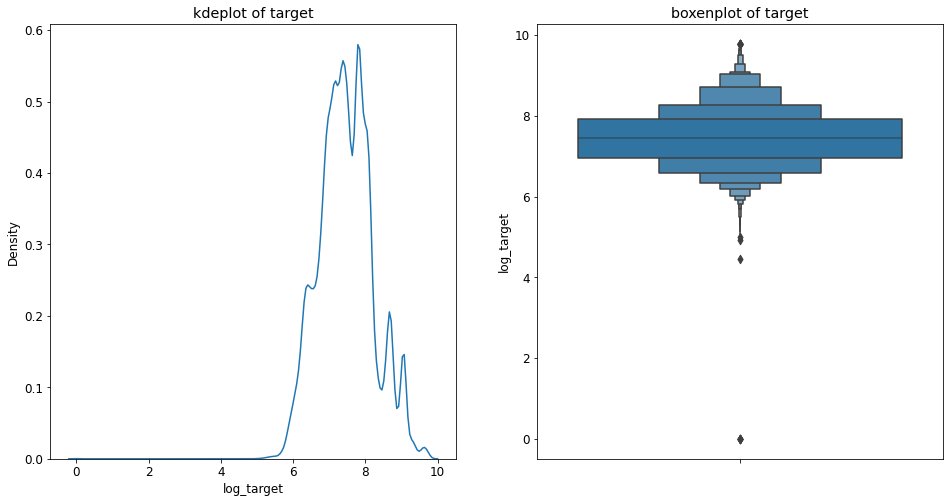

In [9]:
# 정규화가 되어있지 않고 1000~2500까지 많은데이터가 분포되어잇다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.kdeplot(data = train, x = 'log_target', ax = ax[0])
ax[0].set_title('kdeplot of target')

sns.boxenplot(data = train, y = 'log_target', ax = ax[1])
ax[1].set_title('boxenplot of target')

- 이상치가 많은것으로 보여진다.

<AxesSubplot:>

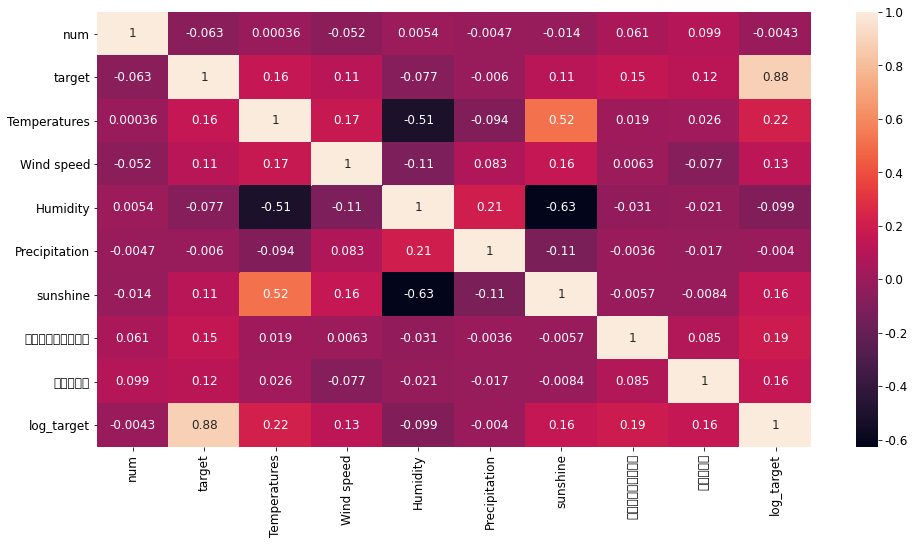

In [10]:
# 변수명이 너무 길기 때문에 변수명을 전부 바꿔준다.
train=train.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm)':'Precipitation','일조(hr)':'sunshine'})

train_corr=train.corr()
plt.figure(figsize = (16,8))
sns.heatmap(train_corr, annot = True)

### test의 결측값이 결측값이 아닌것을 확인했고 우리는 interpolate를 사용하여 채워주자.

In [11]:
# 결측치 채우기
col = ['Temperatures','Wind speed','Humidity','Precipitation','sunshine']
for i in col:
    test[i] = test[i].interpolate()

In [12]:
test

,num,date_time,Temperatures,Wind speed,Humidity,Precipitation,sunshine,비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,NaN,NaN
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,NaN,NaN
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,NaN,NaN
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,NaN,NaN
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,NaN,NaN
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,NaN,NaN
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,NaN,NaN


## num(한 건물을 나타낸다.)

In [13]:
train.num.unique()
# 60개의 건물이 있다는 것을 확인했다.

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

<AxesSubplot:xlabel='num', ylabel='log_target'>

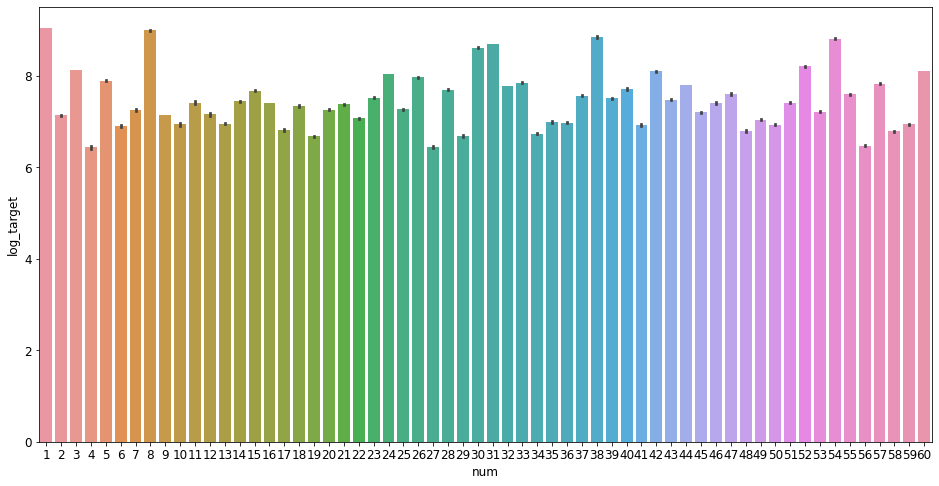

In [14]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'num', y = 'log_target')

- 각 건물마다 전기 사용량이 제각각 다른 것을 확인했다.

<AxesSubplot:xlabel='target', ylabel='Count'>

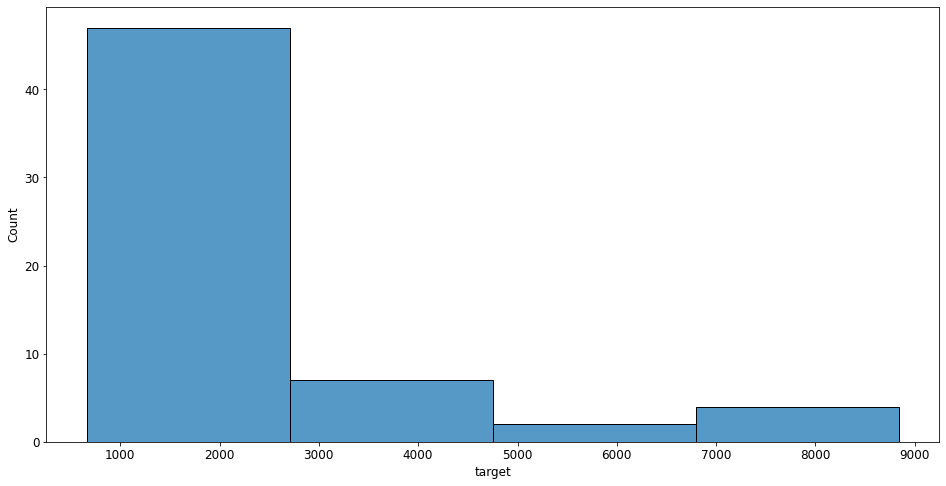

In [15]:
# 4개로 했을 때 가장 두드러지게 나타난다.
sns.histplot(train.groupby('num')['target'].mean(),bins = 4)

In [16]:
mapping=pd.qcut(train.groupby('num')['log_target'].mean(),4 ,labels = [0,1,2,3])
train['num_target'] = train['num'].map(mapping)
test['num_target'] = test['num'].map(mapping)

<AxesSubplot:xlabel='num_target', ylabel='target'>

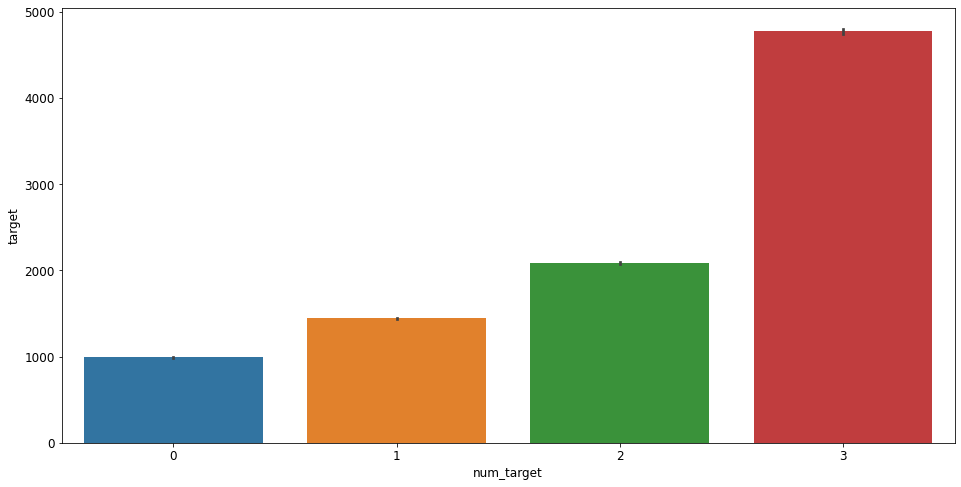

In [17]:
sns.barplot(data = train, x = 'num_target', y = 'target')

## 군집화 수행

In [18]:
train.columns

Index(['num', 'date_time', 'target', 'Temperatures', 'Wind speed', 'Humidity',
       'Precipitation', 'sunshine', '비전기냉방설비운영', '태양광보유', 'log_target',
       'num_target'],
      dtype='object')

In [19]:
from sklearn.cluster import KMeans

# 건물을 예측하는데 필요한 데이터로 다른 데이터를 만든다.
clustering_train= train.groupby('num')[['Temperatures','Wind speed','Humidity','Precipitation','sunshine']].mean()
clustering_test = test.groupby('num')[['Temperatures','Wind speed','Humidity','Precipitation','sunshine']].mean()

# KMeans를 이용하여 라벨링을 하도록 한다.
model = KMeans(n_clusters = 5, random_state = 42)
model.fit(clustering_train)
train_clustering = model.predict(clustering_train)

In [20]:
train_clustering=pd.DataFrame(train_clustering, columns = ['clustering'])
train_clustering['num'] = train['num'].unique()

In [21]:
train_mapping = {}
for num, value in zip(train_clustering['num'], train_clustering['clustering']):
    train_mapping[num] = value

In [22]:
train['clustering'] = train['num'].map(train_mapping)
test['clustering'] = test['num'].map(train_mapping)

## date_time

In [23]:
# 월, 일, 시간 별로 나누는 함수 만들기
def date_time(df, columns = 'date_time'):
    df['month'] = df[columns].apply(lambda x: x[5:7])
    df['day'] = df[columns].apply(lambda x:x[8:10])
    df['hour'] = df[columns].apply(lambda x:x[11:])
    return df
# train데이터에 적용시켜주기
train = date_time(train)

In [24]:
# 평일과 공휴일 함수 만들기
def weekday(df, columns = 'date_time'):
    df[columns]=pd.to_datetime(df[columns])
    df['weekday'] = df[columns].apply(lambda x:x.weekday())
    df['weekday'] = df['weekday'].apply(lambda x:1 if x >4 else 0)
    return df
# 평일과 공휴일 함수 적용시켜주기
train=weekday(df = train)

### 월별 데이터 확인해보기

Text(0.5, 1.0, 'boxnplot - month of target')

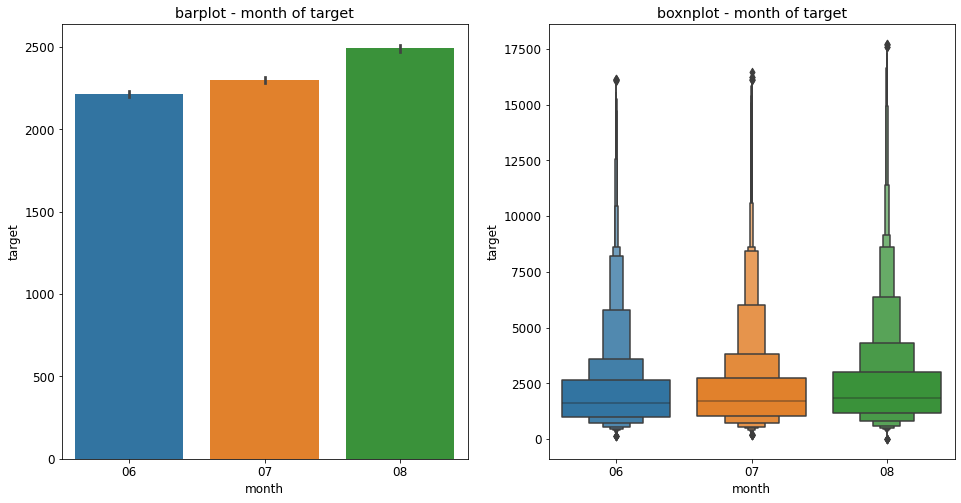

In [25]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('barplot - month of target')

sns.boxenplot(data = train, x= 'month', y = 'target', ax = ax[1])
ax[1].set_title('boxnplot - month of target')

- 시간이 지날수록 더 많은 전력량을 사용하는 것을 알 수 있다.
- 우리는 test값이 8월달의 데이터만 가지고 있기 때문에 어떻게 분석해줄지는 확인해 봐야겠다.

### 일별 확인해 보기

Text(0.5, 1.0, 'boxenplot - day of target')

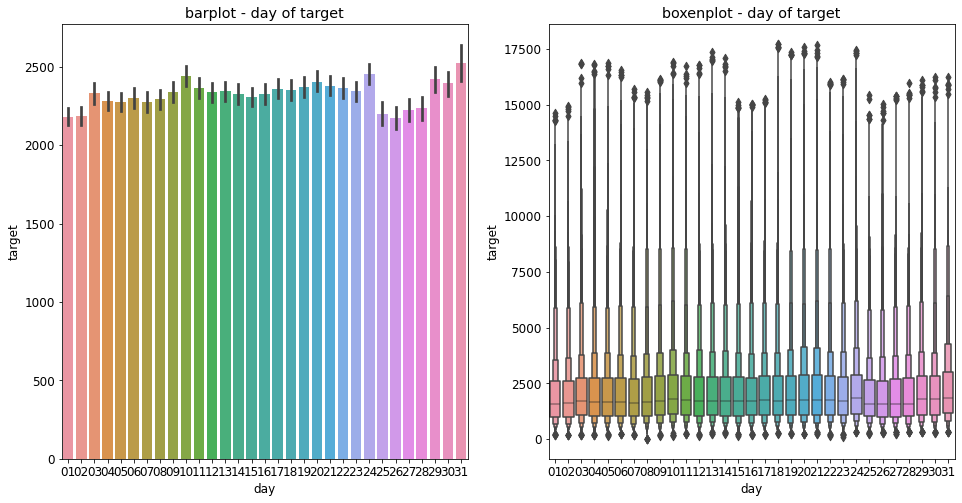

In [26]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', ax = ax[0])
ax[0].set_title('barplot - day of target')

sns.boxenplot(data = train, x = 'day', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - day of target')

- 일별로 큰 차이가 있다고 말 할수는 없을 것 같다

### 시간별 확인해 보기

Text(0.5, 1.0, 'boxenplot - hour of target')

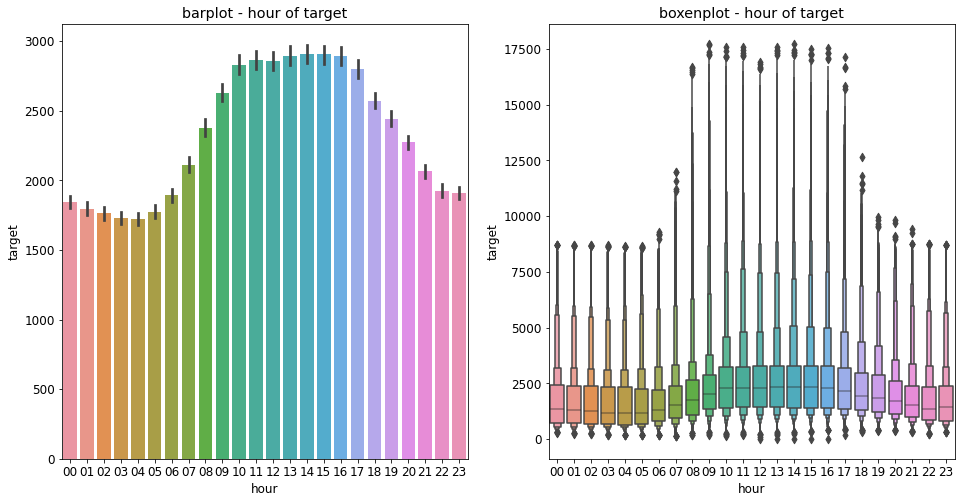

In [27]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', ax = ax[0])
ax[0].set_title('barplot - hour of target')

sns.boxenplot(data = train, x = 'hour', y = 'target', ax = ax[1])
ax[1].set_title('boxenplot - hour of target')

- 시간별로 확실한 차이가 있다고 말할 수 있다.
- 사람들이 활동하는 시간에 전력소모량이 가장 많은 것을 알 수 있다.

### 평일과 주말로 비교해보기

Text(0.5, 1.0, 'boxenplot of weekday')

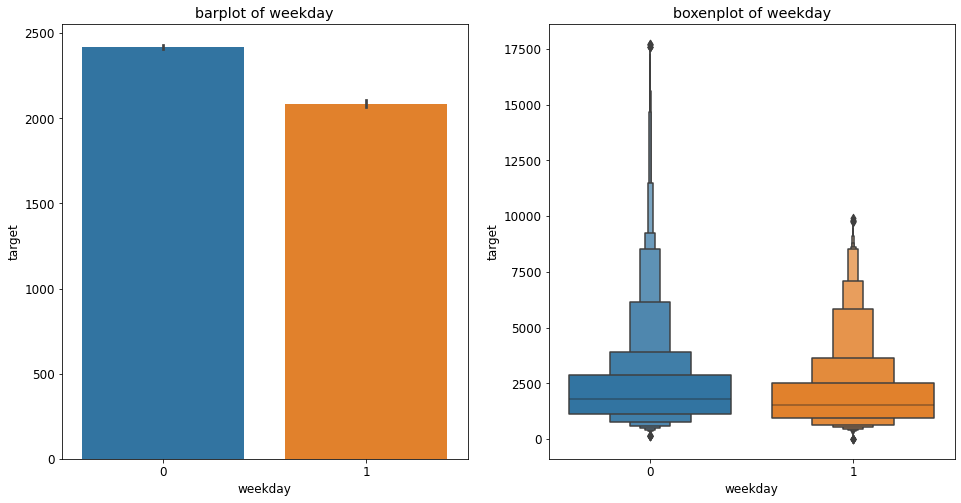

In [28]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('barplot of weekday')

sns.boxenplot(data = train, x = 'weekday', y  ='target', ax = ax[1])
ax[1].set_title('boxenplot of weekday')

- 평일에 많은 전력량을 소모하는 것으로 나타낸다.

Text(0.5, 1.0, 'weekday month target')

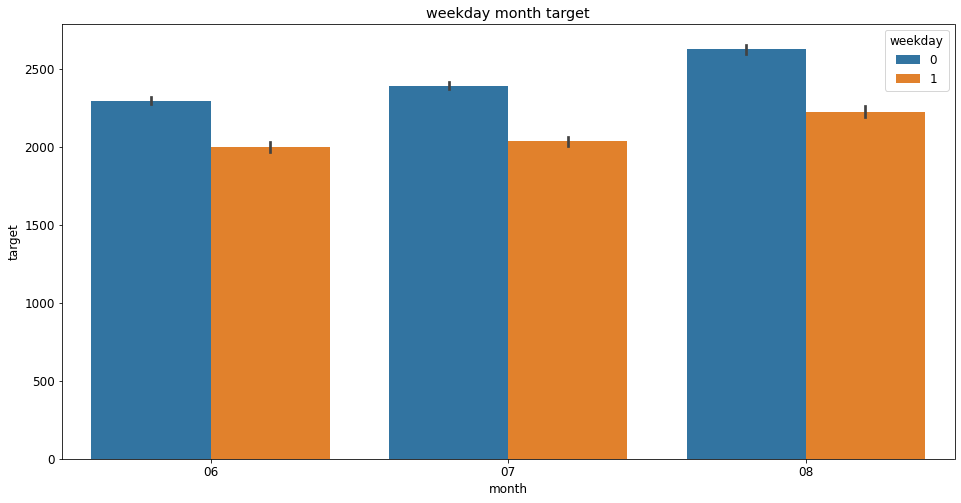

In [29]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', hue = 'weekday')
plt.title('weekday month target')

Text(0.5, 1.0, 'weekday day target')

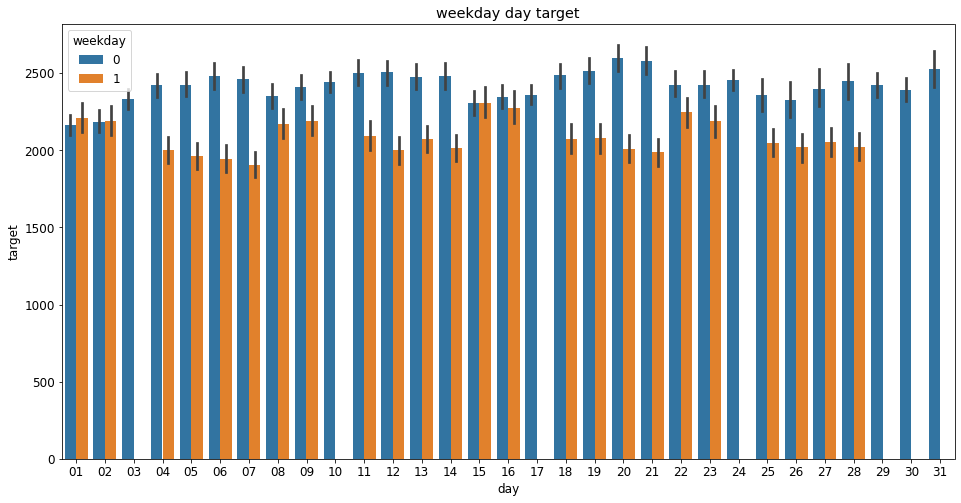

In [30]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target', hue = 'weekday')
plt.title('weekday day target')

- 주말이 없는 날짜가 있기 때문에 표시가 안된 부분도 있다.

Text(0.5, 1.0, 'weekday hour target')

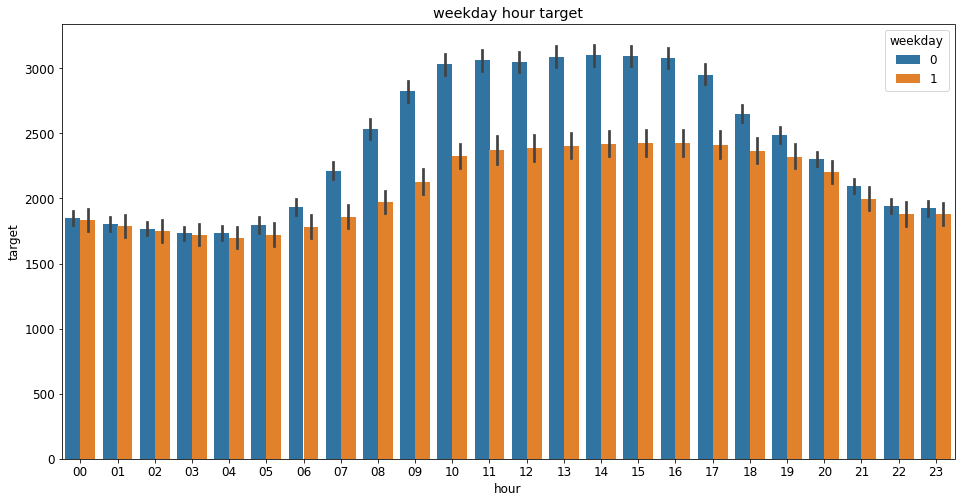

In [31]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')
plt.title('weekday hour target')

## 기온(Temperatures)

In [32]:
# min = 11.1, max = 36.3
train['Temperatures'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: Temperatures, dtype: float64

<AxesSubplot:xlabel='Temperatures', ylabel='Density'>

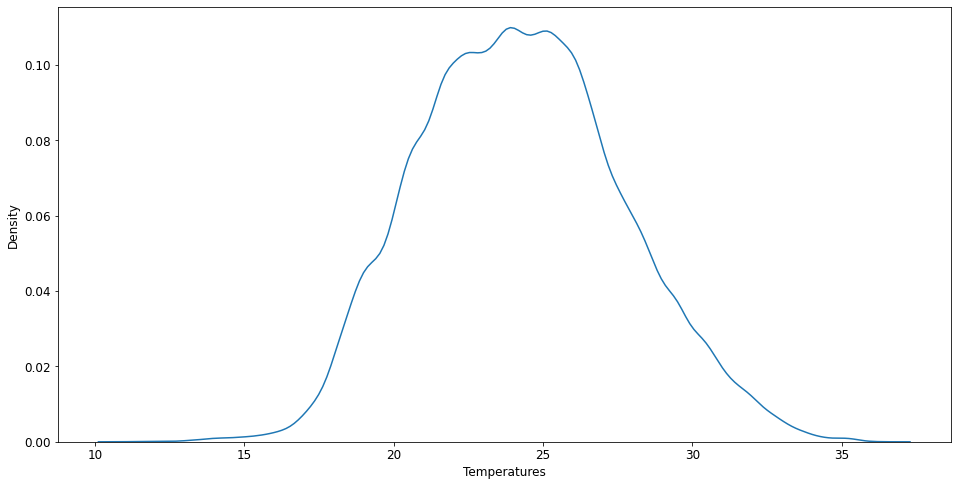

In [33]:
sns.kdeplot(data = train, x = 'Temperatures')

<AxesSubplot:xlabel='Temperatures', ylabel='target'>

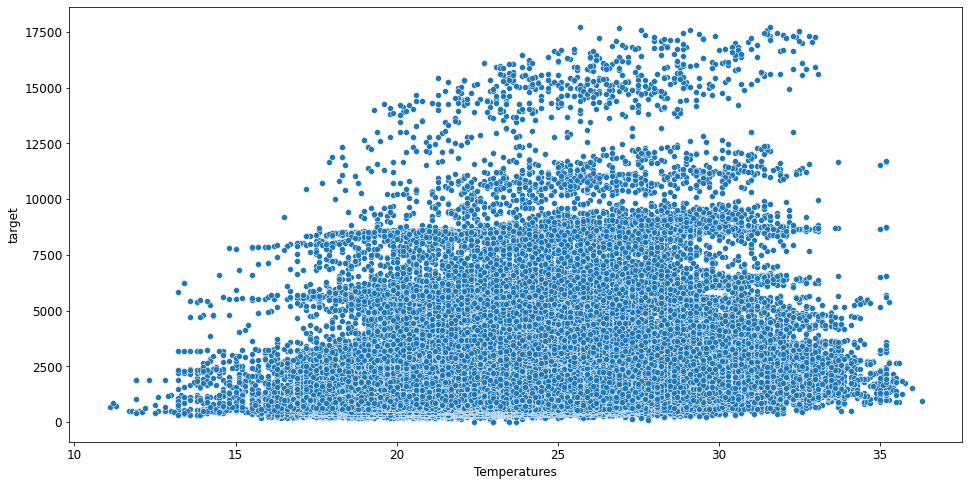

In [34]:
sns.scatterplot(data = train, x = 'Temperatures', y = 'target')

In [35]:
# 이 데이터는 온도에 따라 나눠주는 것이기 때문에 train의 데이터롤 그대로 가지고 와야한다.
train['Temperatures'].describe()

count    122400.000000
mean         24.251713
std           3.407902
min          11.100000
25%          21.800000
50%          24.200000
75%          26.500000
max          36.300000
Name: Temperatures, dtype: float64

In [36]:
train.loc[21.800000 >= train['Temperatures'], 'temperature_binning'] = 0
train.loc[(21.800000 < train['Temperatures']) & (train['Temperatures'] < 24.200000), 'temperature_binning'] = 1
train.loc[(24.200000 < train['Temperatures']) & (train['Temperatures'] < 26.500000), 'temperature_binning'] = 2
train.loc[(26.500000 < train['Temperatures']), 'temperature_binning'] = 3

test.loc[21.800000 >= test['Temperatures'], 'temperature_binning'] = 0
test.loc[(21.800000 < test['Temperatures']) & (test['Temperatures'] < 24.200000), 'temperature_binning'] = 1
test.loc[(24.200000 < test['Temperatures']) & (test['Temperatures'] < 26.500000), 'temperature_binning'] = 2
test.loc[(26.500000 < test['Temperatures']), 'temperature_binning'] = 3

Text(0.5, 1.0, 'temperature_binning boxenplot')

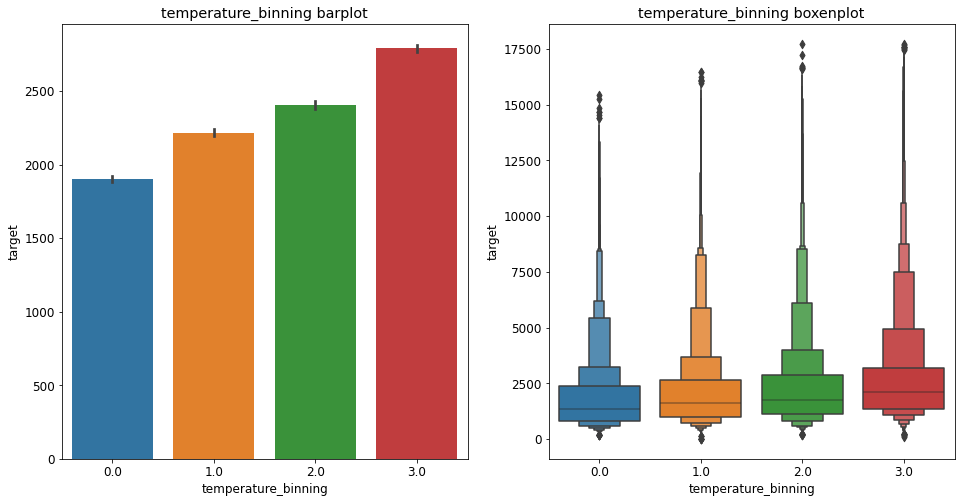

In [37]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[0])
ax[0].set_title('temperature_binning barplot')

sns.boxenplot(data = train, x = 'temperature_binning', y = 'target', ax = ax[1])
ax[1].set_title('temperature_binning boxenplot')

- 이상치가 많은것으로 보이고 이상치는 사용 용도인 num에 따라서 다른 것 같다 우리는 num을 target 별로 군집화 하는게 어떨지 생각해 본다.
- 그게 안된다면 target을 포함한 변수들로 건물의 쓰이는 용도를 군집화 해주는 방법도 좋은 것 같다.

## 풍향(Wind speed)

In [38]:
train['Wind speed'].value_counts()

1.1     4241
1.6     3911
1.5     3831
1.2     3811
1.4     3746
        ... 
16.3       1
16.8       1
11.9       1
15.4       1
16.6       1
Name: Wind speed, Length: 155, dtype: int64

<AxesSubplot:xlabel='Wind speed', ylabel='target'>

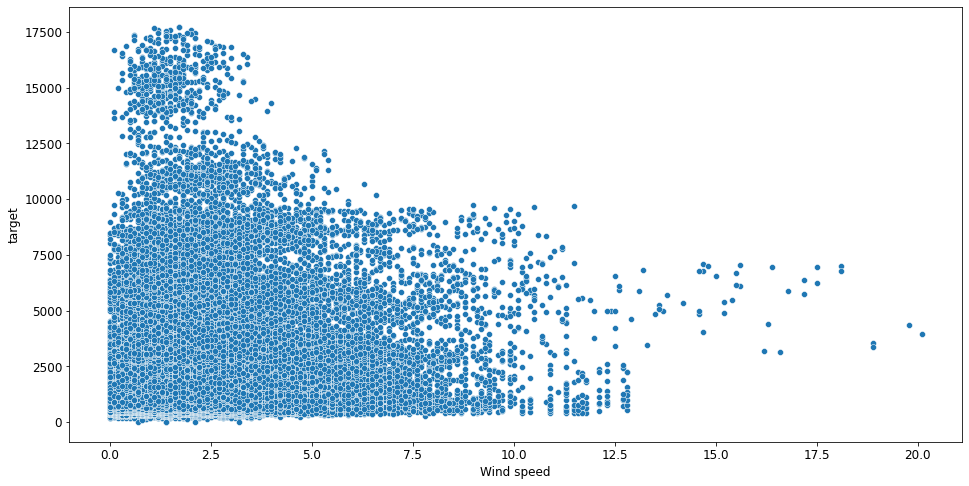

In [39]:
sns.scatterplot(data =train, x = 'Wind speed', y = 'target')

## 습도(Humidity)

In [40]:
train['Humidity'].value_counts

<bound method IndexOpsMixin.value_counts of 0         92.0
1         91.0
2         91.0
3         91.0
4         92.0
          ... 
122395    68.0
122396    71.0
122397    71.0
122398    74.0
122399    75.0
Name: Humidity, Length: 122400, dtype: float64>

<AxesSubplot:xlabel='Humidity', ylabel='target'>

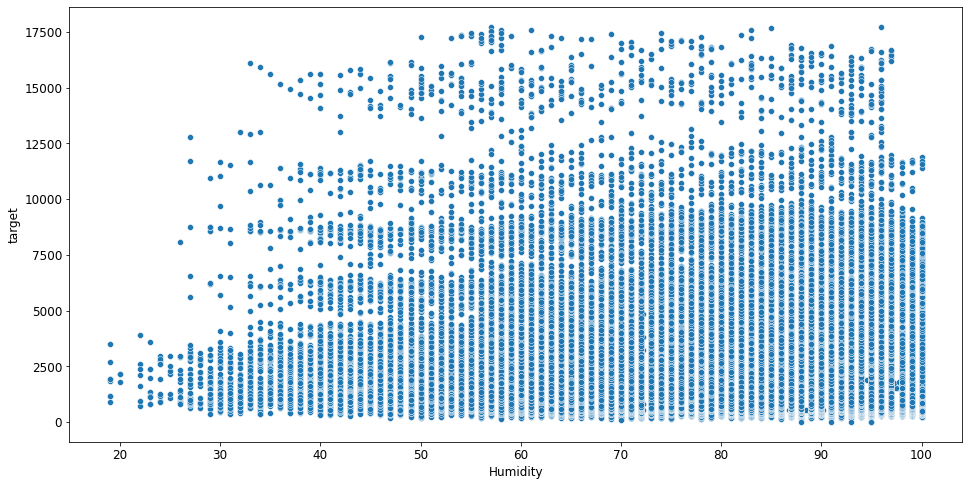

In [41]:
sns.scatterplot(data = train, x = 'Humidity', y = 'target')

## 강수량(Precipitation)

In [42]:
train['Precipitation'].value_counts()

0.0     103473
0.1       2508
0.2       1644
0.3       1171
0.5        830
         ...  
25.1         1
25.2         1
27.9         1
31.0         1
54.6         1
Name: Precipitation, Length: 296, dtype: int64

<AxesSubplot:xlabel='Precipitation', ylabel='target'>

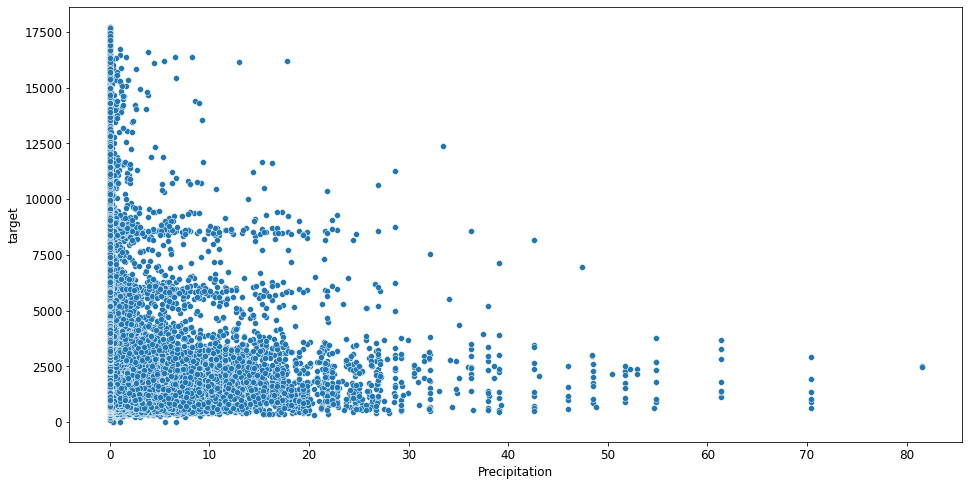

In [43]:
sns.scatterplot(data = train, x = 'Precipitation', y = 'target')

## 일조(sunshine)

In [44]:
train['sunshine'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: sunshine, dtype: int64

<AxesSubplot:xlabel='sunshine', ylabel='target'>

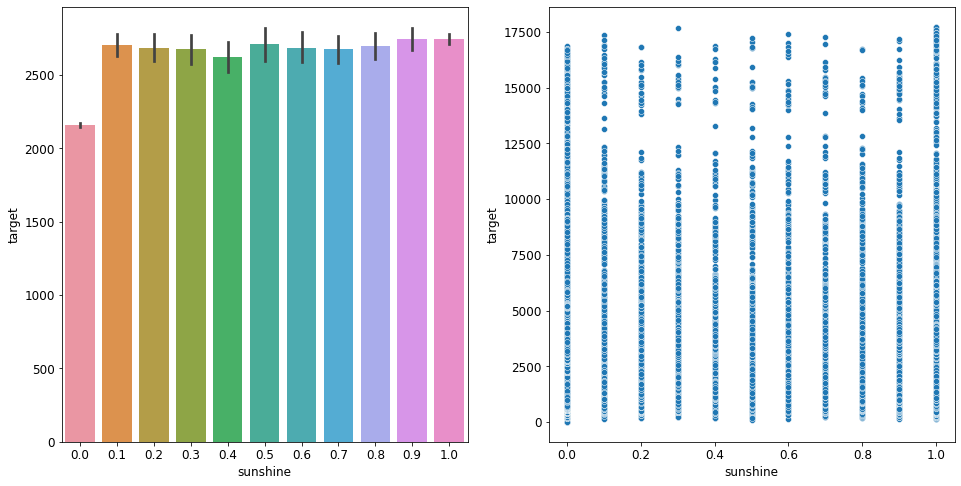

In [45]:
fig, ax = plt.subplots(ncols = 2)
sns.barplot(data = train, x = 'sunshine', y = 'target', ax = ax[0])

sns.scatterplot(data = train, x = 'sunshine', y = 'target', ax = ax[1])

## 비전기냉방설비운영

<AxesSubplot:xlabel='비전기냉방설비운영', ylabel='target'>

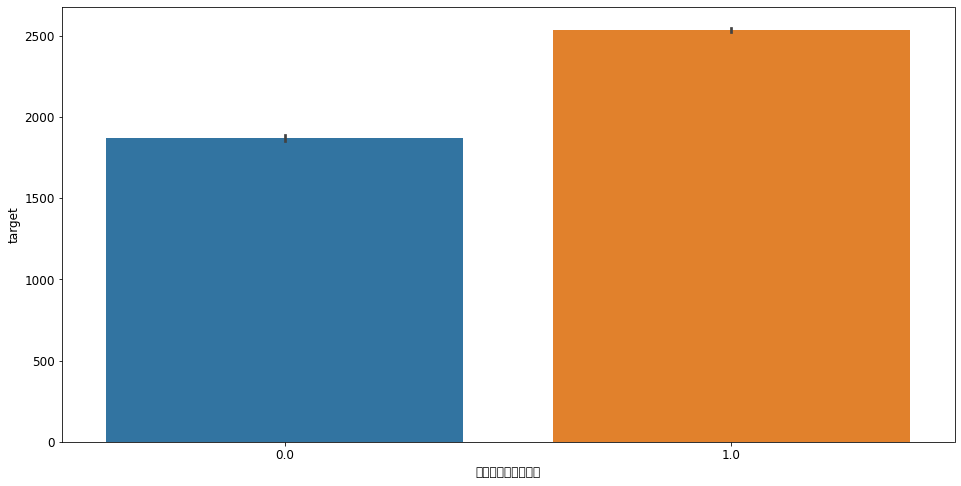

In [46]:
sns.barplot(data = train, x = '비전기냉방설비운영', y = 'target')

In [47]:
# 비전기냉방설비운영을 안하고있다가 하고 있는 곳을 확인했지만 그런 곳은 확인하지 못했다.
비전기냉방설비운영_0=list(train[train['비전기냉방설비운영'] == 0]['num'].unique())
비전기냉방설비운영_1=list(train[train['비전기냉방설비운영'] == 1]['num'].unique())

for i in 비전기냉방설비운영_0:
    비전기냉방설비운영_1.append(i)


len(비전기냉방설비운영_1) == len(train['num'].unique())

True

## 태양광보유

<AxesSubplot:xlabel='태양광보유', ylabel='target'>

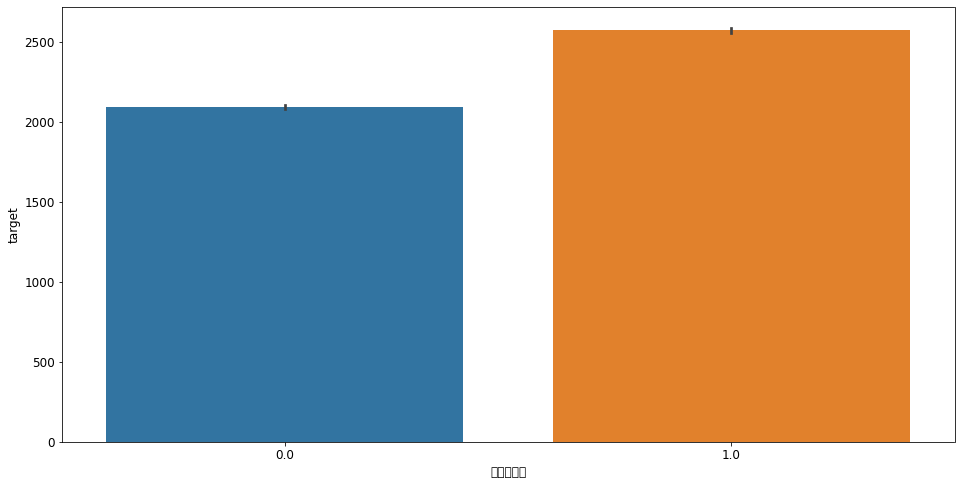

In [48]:
sns.barplot(data = train, x = '태양광보유', y = 'target')

In [49]:
# 태양광을 보유하지 않다가 보유한 건물이 있는지 확인해 보자.
태양광보유_0 = list(train[train['태양광보유'] == 0]['num'].unique())
태양광보유_1 = list(train[train['태양광보유'] == 1]['num'].unique())

for i in 태양광보유_0:
    태양광보유_1.append(i)
    
len(태양광보유_1) == len(train['num'].unique())

True

In [50]:
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 0), 'new_column'] = 0
train.loc[(train['비전기냉방설비운영'] == 0) & (train['태양광보유'] == 1), 'new_column'] = 1
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 0), 'new_column'] = 2
train.loc[(train['비전기냉방설비운영'] == 1) & (train['태양광보유'] == 1), 'new_column'] = 3

<AxesSubplot:xlabel='new_column', ylabel='target'>

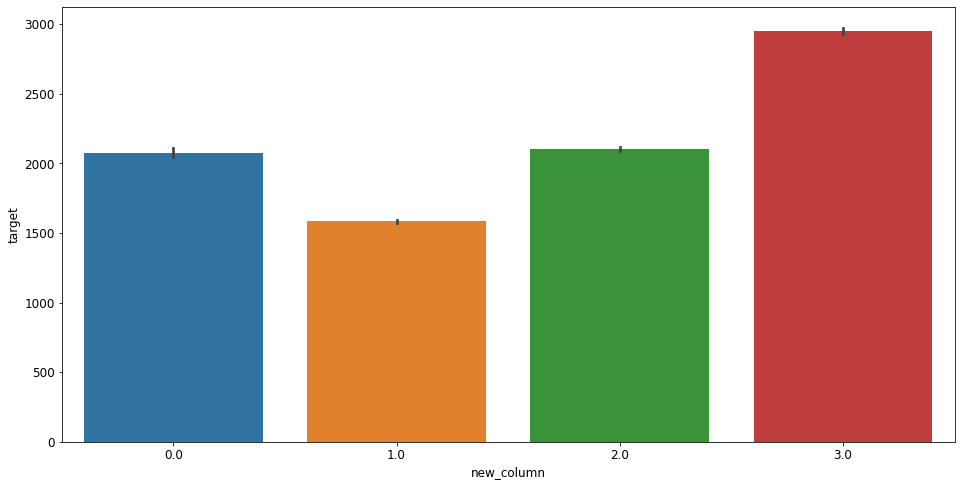

In [51]:
sns.barplot(data = train, x = 'new_column', y = 'target')

## 체감온도 구하기

In [52]:
train['Humidity']

0         92.0
1         91.0
2         91.0
3         91.0
4         92.0
          ... 
122395    68.0
122396    71.0
122397    71.0
122398    74.0
122399    75.0
Name: Humidity, Length: 122400, dtype: float64

In [53]:
train['Humidity'].min()

19.0

In [54]:
def winter_temperature(df = None):
    df['Wind speed km/h'] = df['Wind speed'].apply(lambda x: x*3.6)
    def tem(x):
        V = 'Wind speed km/h'
        T = 'Temperatures'
        temperature= 13.12 + (0.6215*x[T]) - 11.37*((x[V])**0.16) + (0.3965*(x[V] **0.16)*x[T])
        return temperature
    temperature = tem(df)
    df['겨울철 체감온도'] = temperature
    df.drop('Wind speed km/h', axis = 1, inplace = True)
    return df


def summer_temperature(df = None):
    
    def tem1(x):
        T = 'Temperatures'
        H = 'Humidity'
        temperature = x[T] + ((x[H] - 50)* 0.1)
        return temperature
    temperature = tem1(df)
    df['여름철 체감온도'] = temperature
    
    return df

In [55]:
# train= winter_temperature(train)
# test = winter_temperature(test)
                                      
train = summer_temperature(train)
test = summer_temperature(test)

습도 50%를 기준으로 10%가 올라가면 플러스 1도, 떨어지면 마이너스 1도로 치고 폭염주의보와 경보도 기온이 아니라 체감온도를 기준으로 발령하기로 했습니다 

Text(0.5, 1.0, 'summer temperature')

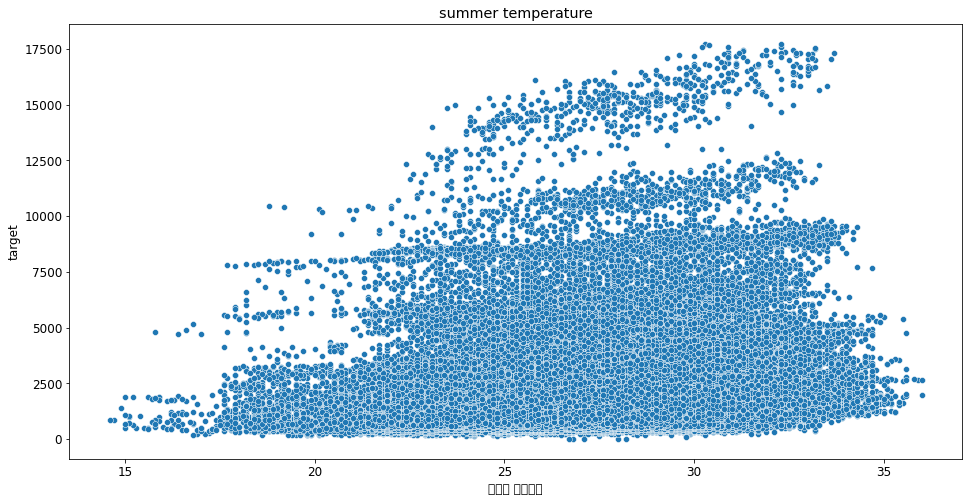

In [56]:
# fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
# sns.scatterplot(data = train, x = '겨울철 체감온도', y = 'target', ax = ax[0])
# ax[0].set_title('winter temperature')

sns.scatterplot(data = train, x = '여름철 체감온도', y = 'target')
plt.title('summer temperature')

## 불쾌지수 구하기

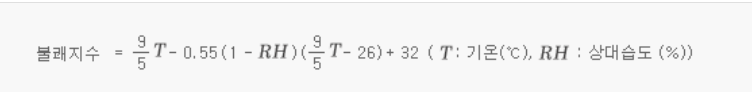

In [57]:
def 불쾌지수구하기(df = None):
    def 불쾌지수구하기(x):
        T = 'Temperatures'
        H = 'Humidity'
        불쾌지수 = (9/5 * x[T]) - (0.55 * (1 - x[H]) * ((9 / 5 * x[T]) - 26)) + 32
        
        return 불쾌지수
    불쾌지수  = 불쾌지수구하기(df)
    df['불쾌지수'] = 불쾌지수
    
    return df

train=불쾌지수구하기(train)
test = 불쾌지수구하기(test)

## Test EDA

In [58]:
test = date_time(test)
test = weekday(df = test)

In [59]:
# 변수명이 너무 길기 때문에 변수명을 전부 바꿔준다.
test=test.rename(columns = {'기온(°C)':'Temperatures', '풍속(m/s)':'Wind speed',
                              '습도(%)':'Humidity',
                              '강수량(mm, 6시간)':'Precipitation','일조(hr, 3시간)':'sunshine'})

In [60]:
test.isnull().sum()

num                       0
date_time                 0
Temperatures              0
Wind speed                0
Humidity                  0
Precipitation             0
sunshine                  0
비전기냉방설비운영              7784
태양광보유                  8456
num_target                0
clustering                0
temperature_binning     125
여름철 체감온도                  0
불쾌지수                      0
month                     0
day                       0
hour                      0
weekday                   0
dtype: int64

In [61]:
print('3시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Temperatures']) - (len(test['Temperatures'])/3))
print('6시간마다 데이터가 입력된다면 결측치의 값 :',len(test['Humidity']) - len(test['Humidity'])/ 6)
# 해당 결측치의 값과 같다.

3시간마다 데이터가 입력된다면 결측치의 값 : 6720.0
6시간마다 데이터가 입력된다면 결측치의 값 : 8400.0


- 기온, 풍속, 습도. 일조는 3시간마다 데이터가 입력되어 있다.
- 그러나 강수량은 6시간마다 데이터가 입력되어 있기 때문에 결측치도 다르다.
- 그래서 이 데이터를 어떻게 해주어야 할지 고민해 봐야겠다.

In [62]:
# Nan값으로 표시된 것은 전부 비전기냉방설비운영을 하지않는 사람인 것 같다.
test['비전기냉방설비운영'].value_counts()

1.0    2296
Name: 비전기냉방설비운영, dtype: int64

In [63]:
# Nan값으로 표시된 것은 전부 태양광보유를 하지 않은 사람이다.
test['태양광보유'].value_counts()

1.0    1624
Name: 태양광보유, dtype: int64

In [64]:
# 그러면 데이터를 같은 id에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 비전기냉방설비운영
for num in test['num'].unique():
    if len(test[test['num'] == num]['비전기냉방설비운영'].value_counts()) == 1:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 1
    else:
        test.loc[test['num'] == num, '비전기냉방설비운영'] = 0

In [65]:
# 그러면 데이터를 같은 id에 1이 있다면 건물을 1을 넣어주고 아니라면 0을 넣어주자.
# 태양광보유
for num in test['num'].unique():
    if len(test[test['num'] == num]['태양광보유'].value_counts()) == 1:
        test.loc[test['num'] == num, '태양광보유'] = 1
    else:
        test.loc[test['num'] == num, '태양광보유'] = 0

In [66]:
print(test['비전기냉방설비운영'].value_counts())
print(test['태양광보유'].value_counts())

1.0    6888
0.0    3192
Name: 비전기냉방설비운영, dtype: int64
0.0    5208
1.0    4872
Name: 태양광보유, dtype: int64


In [67]:
len(test)

10080

In [68]:
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 0), 'new_column'] = 0
test.loc[(test['비전기냉방설비운영'] == 0) & (test['태양광보유'] == 1), 'new_column'] = 1
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 0), 'new_column'] = 2
test.loc[(test['비전기냉방설비운영'] == 1) & (test['태양광보유'] == 1), 'new_column'] = 3

## 모델링

In [71]:
dummies = ['hour','weekday','new_column','temperature_binning','clustering'] # day는 제거해줘야 하는 변수고, month는 달이 오를수록 target변수가 오르므로 그냥 제거해주지 않고 써주도록 하자.
train_data=pd.get_dummies(data = train, columns = dummies)
test_data = pd.get_dummies(data = test, columns = dummies)

drop_columns_train = ['day','date_time','비전기냉방설비운영','태양광보유','Temperatures','num','log_target']
drop_columns_test = ['day','date_time','비전기냉방설비운영','태양광보유','Temperatures','num']
train_data = train_data.drop(drop_columns_train, axis = 1)
test_data = test_data.drop(drop_columns_test, axis = 1)

# month가 object로 들어가 있으므로 int형으로 바꿔준다.
train_data['month'] = train_data['month'].astype('int')
test_data['month'] = test_data['month'].astype('int')
train_data['num_target'] = train_data['num_target'].astype('int')
test_data['num_target'] = test_data['num_target'].astype('int')

# target을 정규화 시킨 이후에 나중에 빼주도록 하자.
train_data['target'] = train_data['target'].apply(lambda x: np.log1p(x))

# train_data를 target변수를 빼주자
target = train_data['target']
train_data = train_data.drop('target', axis = 1)

# test_data에는 temperature_binning 0.0이 없기 때문에 제거해준다.
train_data.drop('temperature_binning_0.0', axis = 1, inplace = True)

In [72]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [78]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(train_data.drop('target', axis = 1), train_data['target'], test_size = 0.2, random_state = 42)
# catboost = CatBoostRegressor()
# catboost.fit(X_train,y_train)
# y_pred=catboost.predict(X_test)
# smape(y_test,y_pred)
# # lightgbm
# lgb=LGBMRegressor(random_state = 42)
# lgb.fit(train_data.drop('target', axis = 1), train_data['target'])
# y_pred=lgb.predict(test_data)


# catboost
catboost = CatBoostRegressor(random_state= 42)
catboost.fit(train_data, target)
y_pred=catboost.predict(test_data)

# # xgboost
# xgb = XGBRegressor(random_state = 42)
# xgb.fit(train_data, target)
# y_pred=xgb.predict(test_data)

 # 정규화 진행해 준것을 원래 데이터에 맞춰주기 위해서 np.exp(x) - 1을 해주고 그것을 csv에 넣어주자.
y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
y_pred['y_pred'] = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

submission['answer'] = y_pred['y_pred']
submission.to_csv('C:/Users/lg/전력사용량 예측 AI 경진대회/submission.csv',index= False)

Learning rate set to 0.091839
0:	learn: 0.6934897	total: 37.7ms	remaining: 37.6s
1:	learn: 0.6524484	total: 72.5ms	remaining: 36.2s
2:	learn: 0.6169833	total: 100ms	remaining: 33.3s
3:	learn: 0.5851517	total: 129ms	remaining: 32s
4:	learn: 0.5571763	total: 157ms	remaining: 31.3s
5:	learn: 0.5330954	total: 193ms	remaining: 32s
6:	learn: 0.5127882	total: 227ms	remaining: 32.3s
7:	learn: 0.4946231	total: 255ms	remaining: 31.6s
8:	learn: 0.4789217	total: 282ms	remaining: 31s
9:	learn: 0.4650362	total: 312ms	remaining: 30.9s
10:	learn: 0.4532414	total: 346ms	remaining: 31.1s
11:	learn: 0.4418607	total: 380ms	remaining: 31.3s
12:	learn: 0.4324312	total: 407ms	remaining: 30.9s
13:	learn: 0.4244981	total: 439ms	remaining: 30.9s
14:	learn: 0.4170436	total: 467ms	remaining: 30.7s
15:	learn: 0.4104615	total: 506ms	remaining: 31.1s
16:	learn: 0.4053328	total: 543ms	remaining: 31.4s
17:	learn: 0.4000399	total: 579ms	remaining: 31.6s
18:	learn: 0.3949850	total: 618ms	remaining: 31.9s
19:	learn: 0.39

165:	learn: 0.2931561	total: 6.81s	remaining: 34.2s
166:	learn: 0.2927923	total: 6.84s	remaining: 34.1s
167:	learn: 0.2925952	total: 6.89s	remaining: 34.1s
168:	learn: 0.2922963	total: 6.92s	remaining: 34s
169:	learn: 0.2921897	total: 7s	remaining: 34.2s
170:	learn: 0.2919610	total: 7.06s	remaining: 34.2s
171:	learn: 0.2918342	total: 7.11s	remaining: 34.2s
172:	learn: 0.2916270	total: 7.17s	remaining: 34.3s
173:	learn: 0.2913431	total: 7.21s	remaining: 34.2s
174:	learn: 0.2911090	total: 7.24s	remaining: 34.1s
175:	learn: 0.2908637	total: 7.29s	remaining: 34.1s
176:	learn: 0.2905175	total: 7.33s	remaining: 34.1s
177:	learn: 0.2903527	total: 7.35s	remaining: 34s
178:	learn: 0.2901944	total: 7.39s	remaining: 33.9s
179:	learn: 0.2900343	total: 7.44s	remaining: 33.9s
180:	learn: 0.2899327	total: 7.48s	remaining: 33.8s
181:	learn: 0.2895614	total: 7.51s	remaining: 33.8s
182:	learn: 0.2890470	total: 7.55s	remaining: 33.7s
183:	learn: 0.2889068	total: 7.58s	remaining: 33.6s
184:	learn: 0.28854

326:	learn: 0.2657532	total: 13.1s	remaining: 26.9s
327:	learn: 0.2656847	total: 13.1s	remaining: 26.9s
328:	learn: 0.2655732	total: 13.1s	remaining: 26.8s
329:	learn: 0.2655097	total: 13.2s	remaining: 26.7s
330:	learn: 0.2653243	total: 13.2s	remaining: 26.7s
331:	learn: 0.2652040	total: 13.2s	remaining: 26.6s
332:	learn: 0.2650850	total: 13.3s	remaining: 26.6s
333:	learn: 0.2649214	total: 13.3s	remaining: 26.5s
334:	learn: 0.2648638	total: 13.3s	remaining: 26.5s
335:	learn: 0.2647030	total: 13.4s	remaining: 26.4s
336:	learn: 0.2646090	total: 13.4s	remaining: 26.4s
337:	learn: 0.2645390	total: 13.4s	remaining: 26.3s
338:	learn: 0.2645008	total: 13.5s	remaining: 26.3s
339:	learn: 0.2644420	total: 13.5s	remaining: 26.2s
340:	learn: 0.2643383	total: 13.5s	remaining: 26.2s
341:	learn: 0.2642272	total: 13.6s	remaining: 26.1s
342:	learn: 0.2641589	total: 13.6s	remaining: 26.1s
343:	learn: 0.2640929	total: 13.6s	remaining: 26s
344:	learn: 0.2640084	total: 13.7s	remaining: 26s
345:	learn: 0.26

485:	learn: 0.2528745	total: 18.5s	remaining: 19.6s
486:	learn: 0.2528322	total: 18.5s	remaining: 19.5s
487:	learn: 0.2528180	total: 18.6s	remaining: 19.5s
488:	learn: 0.2527987	total: 18.6s	remaining: 19.4s
489:	learn: 0.2527043	total: 18.6s	remaining: 19.4s
490:	learn: 0.2526051	total: 18.7s	remaining: 19.4s
491:	learn: 0.2525798	total: 18.7s	remaining: 19.3s
492:	learn: 0.2524752	total: 18.7s	remaining: 19.3s
493:	learn: 0.2524366	total: 18.8s	remaining: 19.2s
494:	learn: 0.2523459	total: 18.8s	remaining: 19.2s
495:	learn: 0.2523073	total: 18.8s	remaining: 19.1s
496:	learn: 0.2522892	total: 18.9s	remaining: 19.1s
497:	learn: 0.2522228	total: 18.9s	remaining: 19.1s
498:	learn: 0.2521229	total: 18.9s	remaining: 19s
499:	learn: 0.2520886	total: 19s	remaining: 19s
500:	learn: 0.2520277	total: 19s	remaining: 18.9s
501:	learn: 0.2520001	total: 19s	remaining: 18.9s
502:	learn: 0.2519286	total: 19.1s	remaining: 18.8s
503:	learn: 0.2518548	total: 19.1s	remaining: 18.8s
504:	learn: 0.2517930	

649:	learn: 0.2445413	total: 23.6s	remaining: 12.7s
650:	learn: 0.2444802	total: 23.7s	remaining: 12.7s
651:	learn: 0.2444556	total: 23.7s	remaining: 12.7s
652:	learn: 0.2444090	total: 23.7s	remaining: 12.6s
653:	learn: 0.2443743	total: 23.8s	remaining: 12.6s
654:	learn: 0.2443386	total: 23.8s	remaining: 12.5s
655:	learn: 0.2443114	total: 23.8s	remaining: 12.5s
656:	learn: 0.2442900	total: 23.9s	remaining: 12.5s
657:	learn: 0.2442690	total: 23.9s	remaining: 12.4s
658:	learn: 0.2442220	total: 23.9s	remaining: 12.4s
659:	learn: 0.2441535	total: 23.9s	remaining: 12.3s
660:	learn: 0.2441161	total: 24s	remaining: 12.3s
661:	learn: 0.2440960	total: 24s	remaining: 12.2s
662:	learn: 0.2440683	total: 24s	remaining: 12.2s
663:	learn: 0.2440124	total: 24s	remaining: 12.2s
664:	learn: 0.2439880	total: 24.1s	remaining: 12.1s
665:	learn: 0.2439564	total: 24.1s	remaining: 12.1s
666:	learn: 0.2439111	total: 24.1s	remaining: 12.1s
667:	learn: 0.2438606	total: 24.2s	remaining: 12s
668:	learn: 0.2438006	

811:	learn: 0.2388210	total: 28.6s	remaining: 6.62s
812:	learn: 0.2387721	total: 28.6s	remaining: 6.58s
813:	learn: 0.2387405	total: 28.6s	remaining: 6.54s
814:	learn: 0.2387122	total: 28.7s	remaining: 6.51s
815:	learn: 0.2386906	total: 28.7s	remaining: 6.47s
816:	learn: 0.2386606	total: 28.7s	remaining: 6.43s
817:	learn: 0.2386243	total: 28.7s	remaining: 6.39s
818:	learn: 0.2385908	total: 28.8s	remaining: 6.36s
819:	learn: 0.2385732	total: 28.8s	remaining: 6.32s
820:	learn: 0.2385511	total: 28.8s	remaining: 6.29s
821:	learn: 0.2385222	total: 28.9s	remaining: 6.25s
822:	learn: 0.2384935	total: 28.9s	remaining: 6.22s
823:	learn: 0.2384519	total: 28.9s	remaining: 6.18s
824:	learn: 0.2384314	total: 29s	remaining: 6.15s
825:	learn: 0.2383964	total: 29s	remaining: 6.11s
826:	learn: 0.2383741	total: 29.1s	remaining: 6.08s
827:	learn: 0.2383513	total: 29.1s	remaining: 6.04s
828:	learn: 0.2382877	total: 29.1s	remaining: 6.01s
829:	learn: 0.2382516	total: 29.2s	remaining: 5.97s
830:	learn: 0.23

970:	learn: 0.2345303	total: 33.7s	remaining: 1s
971:	learn: 0.2345045	total: 33.7s	remaining: 971ms
972:	learn: 0.2344253	total: 33.7s	remaining: 936ms
973:	learn: 0.2344129	total: 33.8s	remaining: 901ms
974:	learn: 0.2343930	total: 33.8s	remaining: 867ms
975:	learn: 0.2343573	total: 33.8s	remaining: 832ms
976:	learn: 0.2343422	total: 33.9s	remaining: 797ms
977:	learn: 0.2343296	total: 33.9s	remaining: 763ms
978:	learn: 0.2343093	total: 33.9s	remaining: 728ms
979:	learn: 0.2342989	total: 34s	remaining: 693ms
980:	learn: 0.2342751	total: 34s	remaining: 659ms
981:	learn: 0.2342550	total: 34s	remaining: 624ms
982:	learn: 0.2342225	total: 34.1s	remaining: 589ms
983:	learn: 0.2341948	total: 34.1s	remaining: 555ms
984:	learn: 0.2341783	total: 34.1s	remaining: 520ms
985:	learn: 0.2341511	total: 34.2s	remaining: 485ms
986:	learn: 0.2341327	total: 34.2s	remaining: 450ms
987:	learn: 0.2341093	total: 34.2s	remaining: 416ms
988:	learn: 0.2340872	total: 34.3s	remaining: 381ms
989:	learn: 0.2340613

In [79]:
y_pred

,y_pred
0,8041.032580
1,7873.954301
2,7696.937135
3,7656.851316
4,7852.067881
...,...
10075,4572.536701
10076,4055.105804
10077,3228.316014
10078,2617.700048


In [80]:
submission

,num_date_time,answer
0,1 2020-08-25 00,8041.032580
1,1 2020-08-25 01,7873.954301
2,1 2020-08-25 02,7696.937135
3,1 2020-08-25 03,7656.851316
4,1 2020-08-25 04,7852.067881
...,...,...
10075,60 2020-08-31 19,4572.536701
10076,60 2020-08-31 20,4055.105804
10077,60 2020-08-31 21,3228.316014
10078,60 2020-08-31 22,2617.700048
